# Importing packages

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import open3d
import pptk
from logging import raiseExceptions
import seaborn as sns
import funcs
import tensorflow as tf

%reload_ext funcs


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2022-07-14 15:59:37.204478: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Data loader

original dataframe size (1066, 18)
 dataframe (688, 4)


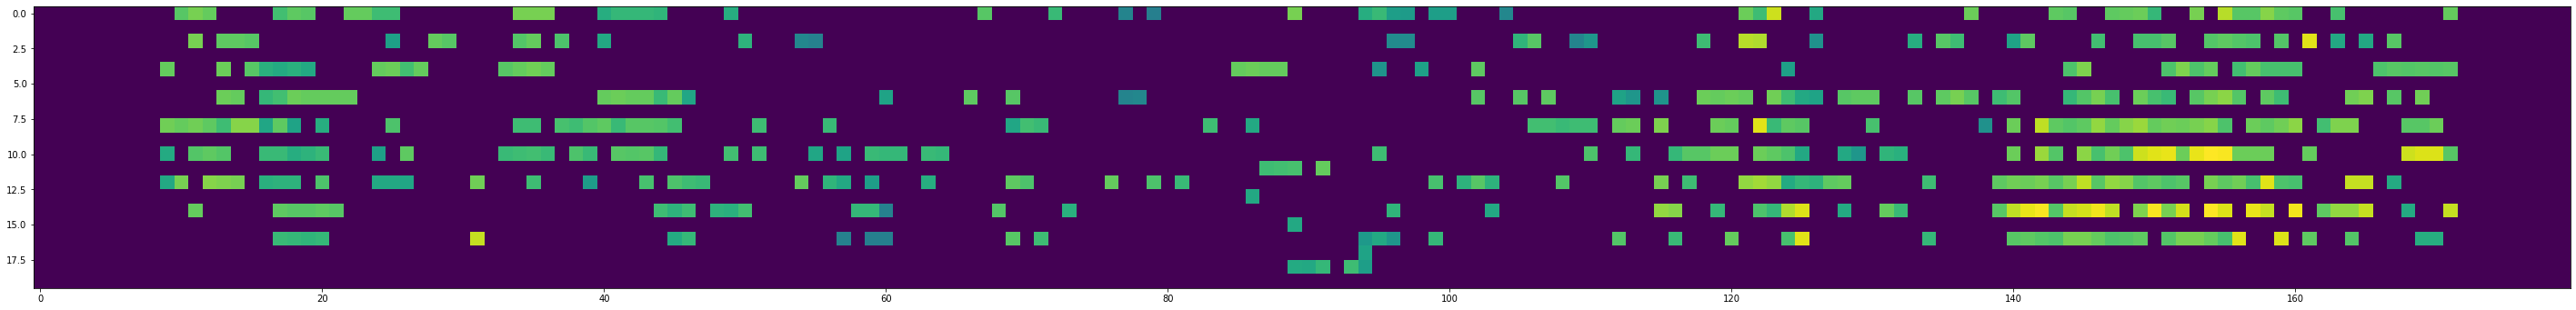

In [2]:
dataloader = funcs.DataLoader(modality='Radar' , data_type='matrix')
dataloader.get_data(filename='1_.txt')

print('original dataframe size', dataloader.dataframe_original.shape)
print(' dataframe',  dataloader.dataframe.shape )

plt.figure(figsize=(50,10))
plt.imshow(dataloader.data_matrix[:,:,0] / dataloader.data_matrix[:,:,0].max() )

In [3]:
x,y,z = dataloader.spherical_to_cartesian( Azimuth_Angle=dataloader.dataframe.Azimuth , Elevation_Angle=dataloader.dataframe.Elevation - 10 , Range=dataloader.dataframe.Range )

# plt.hist(z)

dataloader.dataframe

,Range,Azimuth,Elevation,RCS
0,1,31,16,85
1,1,54,2,43
2,1,55,2,41
3,1,56,8,40
6,1,57,16,41
...,...,...,...,...
1059,485,40,2,56
1060,496,44,0,61
1061,497,47,12,63
1063,499,46,16,62


In [4]:
# dataloader.dataframe_original

## <span style="color:orange; font-size:0.8em"> Viewing the point clouds </span>

In [5]:
columns = dataloader.dataframe.columns[:3]

# funcs.DataLoader().visualize(points=dataloader.dataframe[columns])

In [6]:
dataloader.dataframe[columns]

,Range,Azimuth,Elevation
0,1,31,16
1,1,54,2
2,1,55,2
3,1,56,8
6,1,57,16
...,...,...,...
1059,485,40,2
1060,496,44,0
1061,497,47,12
1063,499,46,16


## <span style="color:orange; font-size:0.8em"> Vector Input </span>

In [7]:
# loader = funcs.VectorInput(filename='1_.txt', modality='Radar')

# print(loader.dataframe.shape)
# print(loader.data.test.shape)

## <span style="color:orange; font-size:0.8em"> Matrix Input </span>

In [8]:
loader = funcs.MatrixInput(modality='Radar')

Loading the dataset: 1683it [00:56, 29.97it/s]
2022-07-14 16:00:35.870775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 16:00:35.907896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-07-14 16:00:35.907915: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-14 16:00:35.908633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized 

Epoch 1/30
106/106 [==============================] - 3s 20ms/step - loss: 0.3393 - val_loss: 0.2039
Epoch 2/30
106/106 [==============================] - 2s 19ms/step - loss: 0.1603 - val_loss: 0.1667
Epoch 3/30
106/106 [==============================] - 2s 18ms/step - loss: 0.1470 - val_loss: 0.1461
Epoch 4/30
106/106 [==============================] - 2s 18ms/step - loss: 0.1384 - val_loss: 0.1354
Epoch 5/30
106/106 [==============================] - 2s 19ms/step - loss: 0.1322 - val_loss: 0.1300
Epoch 6/30
106/106 [==============================] - 2s 18ms/step - loss: 0.1271 - val_loss: 0.1256
Epoch 7/30
106/106 [==============================] - 2s 18ms/step - loss: 0.1235 - val_loss: 0.1223
Epoch 8/30
106/106 [==============================] - 2s 18ms/step - loss: 0.1208 - val_loss: 0.1199
Epoch 9/30
106/106 [==============================] - 2s 18ms/step - loss: 0.1187 - val_loss: 0.1182
Epoch 10/30
106/106 [==============================] - 2s 19ms/step - loss: 0.1168 - val_lo

(<AxesSubplot:title={'center':'input'}>,
 Text(0.5, 1.0, 'input'))

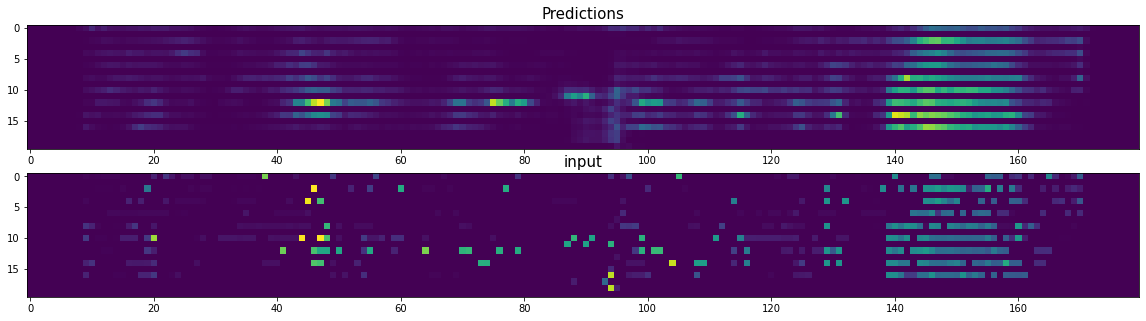

In [9]:
sample_ix = 10
channel = 1

plt.figure(figsize=(20,5))
plt.subplot(211), plt.imshow(loader.predictions[sample_ix,:,:,channel]), plt.title("Predictions", fontsize=15)
plt.subplot(212), plt.imshow(loader.dataset[sample_ix,:,:,channel]), plt.title("input", fontsize=15)

In [11]:
sample_ix = 10


# sample = loader.dataset[sample_ix,...]
sample = loader.predictions[sample_ix,...]



pred = loader.extract_spherical_coordinates(sample)

loader.visualize(points=pred, method='open3d')

In [12]:
from scipy.io import loadmat

In [21]:
out = loadmat('/home/artin/Documents/coordinates.mat')

In [33]:
points = np.array([out['x'],out['y'],out['z']])

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(points[...,0].T)
open3d.visualization.draw_geometries([pcd])

In [35]:
points = np.array([out['xr'],out['yr'],out['zr']])

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(points[...,0].T)
open3d.visualization.draw_geometries([pcd])